This notebook establishes the experimental variability between laboratories, which we use as an estimate of the aleatoric uncertainty. 

In [358]:
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib import cm
import seaborn as sns
from pathlib import Path
from sklearn.metrics import mean_squared_error

matplotlib.rcParams.update({'font.style': 'normal'})
matplotlib.rcParams.update({'font.sans-serif': 'Segoe UI'})
matplotlib.rcParams.update({'font.size': 26})

colors = sns.color_palette(palette='Accent').as_hex()

In [321]:
def solutions_different_sources(df1, df1name, df2, df2name, temp_threshold):
    merged_df = pd.merge(df1, df2, on=['solute_smiles', 'solvent_smiles'], suffixes=('_' + df1name, '_' + df2name))
    merged_df['temp_diff'] = abs(merged_df['temperature_' + df1name] - merged_df['temperature_' + df2name])
    merged_df = merged_df[merged_df['temp_diff'] <= temp_threshold]

    # Drop duplicates where solute/solvent/temperature is the same between datasets
    merged_df = merged_df.sort_values(by='temp_diff')  # Sort by temp_diff
    merged_df = merged_df.drop_duplicates(subset=['solute_smiles', 'solvent_smiles', 
                                                  'temperature_' + df1name], keep='first')  # Handle df1 duplicates
    merged_df = merged_df.drop_duplicates(subset=['solute_smiles', 'solvent_smiles', 
                                                  'temperature_' + df2name], keep='first')  # Handle df2 duplicates

    # Filter rows where the source is different for each dataset
    solutions_with_different_sources = merged_df[~merged_df.apply(
        lambda row: row['source_' + df1name] in row['source_' + df2name] or row['source_' + df2name] in row['source_' + df1name],
        axis=1)]
    RMSE = np.sqrt(mean_squared_error(
        solutions_with_different_sources["logS_" + df1name], solutions_with_different_sources["logS_" + df2name]))

    return RMSE, solutions_with_different_sources

def test_duplicates(df, cols_to_check):
    duplicate_rows = df[df.duplicated(subset=cols_to_check, keep=False)]
    return duplicate_rows

In [325]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\data")
bigsol: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, r"krasnov\bigsol.csv"))
solprop: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "SolProp_v1.2\Data\CombiSolu-Exp.csv"))

leeds_acetone: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds/acetone_solubility_data.csv"))
leeds_acetone['solvent_smiles'] = 'CC(=O)C'

leeds_benzene: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds/benzene_solubility_data.csv"))
leeds_benzene['solvent_smiles'] = 'C1=CC=CC=C1'


leeds_ethanol: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds/ethanol_solubility_data.csv"))
leeds_ethanol['solvent_smiles'] = 'CCO'

leeds = pd.concat([leeds_acetone, leeds_benzene, leeds_ethanol], ignore_index=True, axis=0) 

In [328]:
solprop = solprop.rename(columns={'experimental_logS [mol/L]': 'logS_solprop'})
leeds = leeds.rename(columns={'SMILES': 'solute_smiles'})
leeds = leeds.rename(columns={'Source': 'source'})
leeds = leeds.rename(columns={'T': 'temperature'})
leeds = leeds.rename(columns={'LogS': 'logS_leeds'})
leeds['temperature'] = leeds['temperature'] + 273.15

bigsol = bigsol.rename(columns={'logS': 'logS_bigsol'})

Now that we have our datasets shaped and processed, we will use our function to find overlapping solutions in each dataset that come from different sources, whether a paper or compiled databse like Reaxys. 

SolProp and BigSol

In [338]:
RMSE, solutions_with_different_sources_solprop_bigsol = solutions_different_sources(solprop, 'solprop', bigsol, 'bigsol', 2)
print(RMSE)
#testing function works
# cols_to_check = ['solute_smiles', 'solvent_smiles', 'temperature_solprop']
# duplicates = test_duplicates(solutions_with_different_sources_solprop_bigsol, cols_to_check)
# print(len(duplicates))

0.9825194809081165


Leeds and Solprop

In [331]:
RMSE, solutions_with_different_sources_solprop_leeds = solutions_different_sources(solprop, 'solprop', leeds, 'leeds', 2)
print(RMSE)

0.0006992831709697889


Leeds and Bigsol

In [339]:
RMSE, solutions_with_different_sources_bigsol_leeds = solutions_different_sources(bigsol, 'bigsol', leeds, 'leeds', 2)
print(RMSE)

0.5435266516092615


Now, we create a dataframe that contains all of the overlapping solutions with non-overlapping sources in a single dataset. 

In [351]:
merged_dfs = [
    (solutions_with_different_sources_bigsol_leeds, 'bigsol', 'leeds'),
    (solutions_with_different_sources_solprop_bigsol, 'solprop', 'bigsol'),
    (solutions_with_different_sources_solprop_leeds, 'solprop', 'leeds')
]

final_dfs = []

for df, name1, name2 in merged_dfs:
    df_final = df[['solute_smiles', 'solvent_smiles', 'temp_diff',
                   f'logS_{name1}', f'logS_{name2}',
                   f'temperature_{name1}', f'temperature_{name2}',
                   f'source_{name1}', f'source_{name2}']].copy()
    
    # Rename columns to standardized names
    df_final = df_final.rename(columns={
        f'logS_{name1}': 'logS_1',
        f'logS_{name2}': 'logS_2',
        f'temperature_{name1}': 'temperature_1',
        f'temperature_{name2}': 'temperature_2',
        f'source_{name1}': 'source_1',
        f'source_{name2}': 'source_2'
    })
    
    df_final['dataset1'] = name1
    df_final['dataset2'] = name2
    
    final_dfs.append(df_final)

# Concatenate all merged dataframes
final_df = pd.concat(final_dfs, ignore_index=True)
final_df['squared_residual'] = (final_df['logS_1'] - final_df['logS_2'])**2
final_df

,solute_smiles,solvent_smiles,temp_diff,logS_1,logS_2,temperature_1,temperature_2,source_1,source_2,dataset1,dataset2,squared_residual
0,c1ccc2cc3ccccc3cc2c1,CCO,0.00,-2.137000,-2.103701,298.15,298.15,10.1021/acs.jced.8b00536,Reaxys,bigsol,leeds,1.108839e-03
1,C1CN2CCN1CC2,CCO,0.01,0.778099,-0.798443,298.15,298.14,10.1021/je8005375,Reaxys,bigsol,leeds,2.485484e+00
2,CC(C)(O)P1(=O)OCC2(CO1)COP(=O)(C(C)(C)O)OC2,CCO,0.01,-1.502907,-1.501169,297.63,297.62,10.1021/je700050r,Reaxys,bigsol,leeds,3.020238e-06
3,CC1(C)COP(=O)(C(C)(C)O)OC1,CCO,0.01,-0.225714,-0.223633,298.35,298.34,10.1021/je4003114,Reaxys,bigsol,leeds,4.327869e-06
4,COc1cnc(Cl)nc1Cl,CCO,0.01,-0.093006,-0.090406,299.44,299.43,10.1021/je9005689,Reaxys,bigsol,leeds,6.759470e-06
5,C1N2CN3CN1CN(C2)C3,CCO,0.34,-0.783967,-0.788571,293.49,293.15,10.1021/je800662m,Reaxys,bigsol,leeds,2.119718e-05
6,CCCCCCCCCCCC(=O)O,CCO,0.99,0.520809,0.555510,294.14,293.15,10.1021/je500222s,Reaxys,bigsol,leeds,1.204169e-03
7,CC(=O)NCC(=O)O,CCO,1.01,-1.072350,-1.086940,298.15,297.14,10.1021/acs.jced.0c00983,Reaxys,bigsol,leeds,2.128754e-04
8,CCCCCCCCCCCCCCCCCC(=O)O,CCO,1.70,-1.013380,-0.600166,299.85,298.15,10.1021/je7006567,Reaxys,bigsol,leeds,1.707458e-01
9,CC(=O)NCC(=O)O,CC#N,0.00,-1.122199,-2.369909,283.15,283.15,https://doi.org/0.4172/2160-7544.1000166,10.1021/acs.jced.0c00983,solprop,bigsol,1.556782e+00


In [352]:
#final_df = final_df.sort_values(by='squared_residual', ascending=False).iloc[1:] #drop outlier 

unique_solvents = final_df['solvent_smiles'].nunique()
unique_solutes = final_df['solute_smiles'].nunique()

print("There are " +str(len(final_df)) + " solutions with different sources, containing " + str(unique_solutes) + " unique solutes, and " + str(unique_solvents) + " unique solvents.")

RMSE = np.sqrt(mean_squared_error(final_df["logS_1"], final_df["logS_2"]))
print("Overall inter-laboratory experimental variability has RMSE = " + f"{RMSE}")

There are 19 solutions with different sources, containing 9 unique solutes, and 5 unique solvents.
Overall inter-laboratory experimental variability has RMSE = 0.7727903048917408


Plot distribution of error

C:\Users\ChemeGrad2021\AppData\Local\Temp\ipykernel_24716\675328189.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_distributions = final_df.groupby("logS_bin")["squared_residual"].apply(list)
C:\Users\ChemeGrad2021\AppData\Local\Temp\ipykernel_24716\675328189.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_bin_mse = np.sqrt(final_df.groupby("logS_bin")["squared_residual"].sum() / final_df.groupby("logS_bin")["squared_residual"].count())


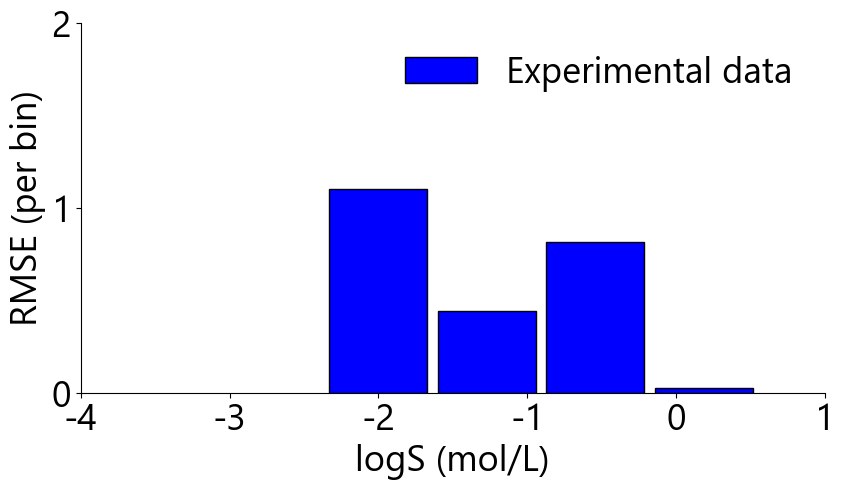

In [353]:
bin_edges = np.linspace(final_df['logS_2'].min(), final_df['logS_2'].max(), 5)  # bins
final_df["logS_bin"] = pd.cut(final_df["logS_2"], bins=bin_edges, include_lowest=True)
error_distributions = final_df.groupby("logS_bin")["squared_residual"].apply(list)
per_bin_mse = np.sqrt(final_df.groupby("logS_bin")["squared_residual"].sum() / final_df.groupby("logS_bin")["squared_residual"].count())
bin_centers = [interval.mid for interval in per_bin_mse.index.categories]

plt.figure(figsize=(6.4*1.5, 4.8))
ax1 = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1, rowspan = 1)
ax1.spines[['top', 'right',]].set_visible(False)
ax1.bar(bin_centers, per_bin_mse, width=np.diff(bin_edges).mean() * 0.9, edgecolor="black", color = 'blue', alpha = 1, label = 'Experimental data')
ax1.set_ylabel("RMSE (per bin)")

ax1.set_xlabel("logS (mol/L)")
#ax1.set_ylabel("Squared Error (mean per bin)")
ax1.set_xticks(
    ticks=[-4, -3, -2, -1,0, 1], 
    labels=[-4, -3, -2, -1,0, 1]
    )
ax1.set_yticks([0, 1, 2])
#ax1.set_yticks([0, 100, 200, 300])

ax1.legend(frameon= False)


C:\Users\ChemeGrad2021\AppData\Local\Temp\ipykernel_24716\2308847652.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_bin_mse = np.sqrt(final_df.groupby("logS_bin")["squared_residual"].sum() / final_df.groupby("logS_bin")["squared_residual"].count())


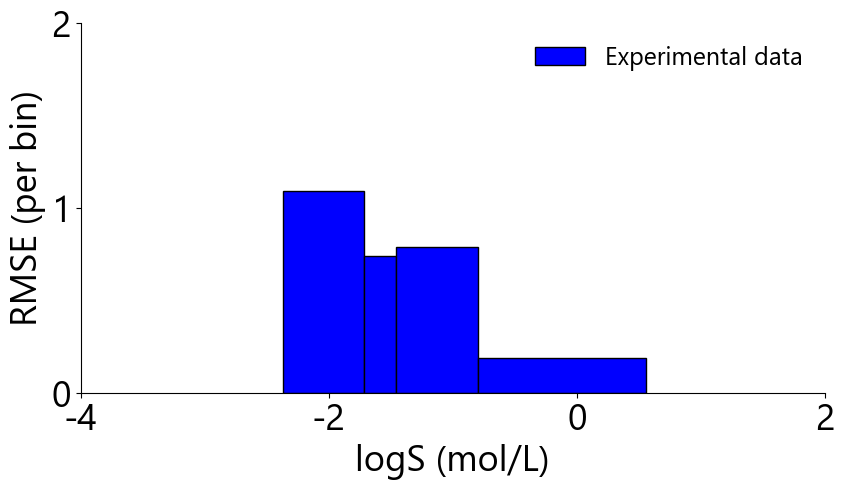

In [355]:
num_bins = 4
final_df["logS_bin"] = pd.qcut(final_df["logS_2"], q=num_bins, duplicates="drop")
per_bin_mse = np.sqrt(final_df.groupby("logS_bin")["squared_residual"].sum() / final_df.groupby("logS_bin")["squared_residual"].count())
bin_centers = [
    (interval.left + interval.right) / 2 for interval in per_bin_mse.index.categories
]

# Get actual bin edges from qcut
bin_edges = [interval.left for interval in per_bin_mse.index.categories]
bin_edges.append(per_bin_mse.index.categories[-1].right)  # Add last edge
bin_widths = np.diff(bin_edges)
bin_starts = bin_edges[:-1]  # Remove last element (last edge)

plt.figure(figsize=(6.4*1.5, 4.8))
ax1 = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1, rowspan = 1)
ax1.spines[['top', 'right',]].set_visible(False)
ax1.bar(bin_starts, per_bin_mse, width=bin_widths, align = 'edge', edgecolor="black", color = 'blue', alpha = 1, label = 'Experimental data')
ax1.set_ylabel("RMSE (per bin)")

ax1.set_xlabel("logS (mol/L)")
#ax1.set_ylabel("Squared Error (mean per bin)")
ax1.set_xticks(
    ticks=[-4, -2, 0, 2], 
    labels=[-4, -2, 0, 2]
    )
ax1.set_yticks([0, 1, 2])
#ax1.set_yticks([0, 100, 200, 300])

ax1.legend(loc = 'upper right', frameon= False ,prop={'size':18})


There is a single solution with multiple temperature points, so we will take a look at this one specifically. 

In [357]:
filtered_df = final_df.groupby(['solute_smiles', 'solvent_smiles']).filter(lambda x: len(x) >= 5)


,solute_smiles,solvent_smiles,temp_diff,logS_1,logS_2,temperature_1,temperature_2,source_1,source_2,dataset1,dataset2,squared_residual,logS_bin
9,CC(=O)NCC(=O)O,CC#N,0.0,-1.122199,-2.369909,283.15,283.15,https://doi.org/0.4172/2160-7544.1000166,10.1021/acs.jced.0c00983,solprop,bigsol,1.556782,"(-2.371, -1.719]"
10,CC(=O)NCC(=O)O,CC#N,0.0,-0.439511,-1.607766,333.15,333.15,https://doi.org/0.4172/2160-7544.1000166,10.1021/acs.jced.0c00983,solprop,bigsol,1.364819,"(-1.719, -1.456]"
14,CC(=O)NCC(=O)O,CC#N,0.0,-0.510873,-1.680364,328.15,328.15,https://doi.org/0.4172/2160-7544.1000166,10.1021/acs.jced.0c00983,solprop,bigsol,1.367708,"(-1.719, -1.456]"
15,CC(=O)NCC(=O)O,CC#N,0.0,-0.704752,-1.933573,313.15,313.15,https://doi.org/0.4172/2160-7544.1000166,10.1021/acs.jced.0c00983,solprop,bigsol,1.510001,"(-2.371, -1.719]"
16,CC(=O)NCC(=O)O,CC#N,0.0,-0.645527,-1.876833,318.15,318.15,https://doi.org/0.4172/2160-7544.1000166,10.1021/acs.jced.0c00983,solprop,bigsol,1.516116,"(-2.371, -1.719]"
17,CC(=O)NCC(=O)O,CC#N,0.0,-0.590624,-1.757655,323.15,323.15,https://doi.org/0.4172/2160-7544.1000166,10.1021/acs.jced.0c00983,solprop,bigsol,1.361962,"(-2.371, -1.719]"


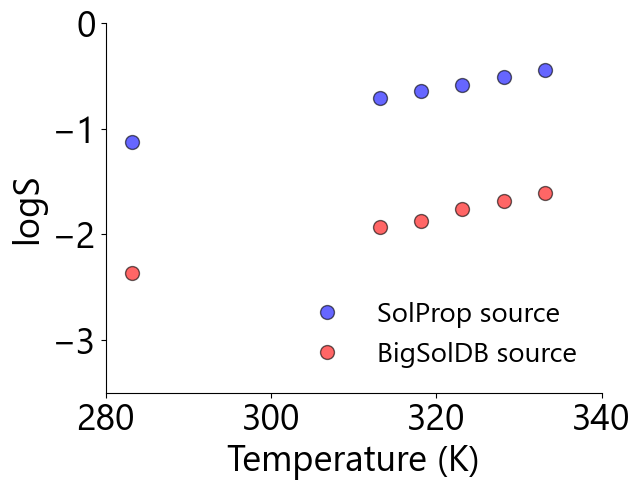

In [388]:
plt.figure(figsize=(6.4, 4.8))
ax1 = plt.gca()
rmse = np.sqrt(mean_squared_error(
        filtered_df["logS_1" ], filtered_df["logS_2"]))

#ax1.plot(300, 0, marker = 'none', linestyle = 'none',  label = r"RMSE = " + f"{rmse:.2f}")
ax1.plot(filtered_df['temperature_1'], filtered_df['logS_1'], color='b', marker = 'o', markersize = 10, linestyle = 'none', markeredgecolor = 'black', alpha = 0.6, label='SolProp source')
ax1.plot(filtered_df['temperature_1'], filtered_df['logS_2'], color='r', marker = 'o', markersize = 10, linestyle = 'none', markeredgecolor = 'black', alpha = 0.6, label='BigSolDB source')

ax1.set_xlabel("Temperature (K)")
ax1.set_ylabel("logS")
ax1.set_xticks([280, 300, 320, 340])
ax1.set_ylim([-3.5, 0])
ax1.legend(prop={'size': 20}, loc = 'lower right', frameon = False) 
ax1.spines[['right', 'top']].set_visible(False)
